In [65]:
import os
import sys
import pandas as pd

# 1. Configuración de la ruta para importar src en un Jupyter Notebook
ruta_raiz = os.path.abspath(os.path.join(os.getcwd(), "..")) 

if ruta_raiz not in sys.path:
    sys.path.insert(0, ruta_raiz)

# Importamos la función para descargar Parquet
from src.common.minio_client import download_df_parquet

# 2. Obtenemos las credenciales
access_key = os.getenv("MINIO_ACCESS_KEY")
if access_key is None:
    raise AssertionError("MINIO_ACCESS_KEY no definida. Configúrala antes de ejecutar.")

secret_key = os.getenv("MINIO_SECRET_KEY")
if secret_key is None:
    raise AssertionError("MINIO_SECRET_KEY no definida. Configúrala antes de ejecutar.")


dia_descarga = "2025-01-02"
nombreGTFS = f"gtfs_scheduled_{dia_descarga}.parquet" 
nombreEvento = f"eventos_{dia_descarga}.parquet" 


ruta_parquet_scheduled = f"grupo5/cleaned/gtfs_clean_scheduled/date={dia_descarga}/{nombreGTFS}"
ruta_parquet_eventos = f"grupo5/cleaned/eventos_nyc/date={dia_descarga}/{nombreEvento}"


try:
    
    
  
    df_s = download_df_parquet(
        access_key=access_key, 
        secret_key=secret_key, 
        object_name=ruta_parquet_scheduled
    )

    df_e = download_df_parquet(
        access_key=access_key, 
        secret_key=secret_key, 
        object_name=ruta_parquet_eventos
    )
    
    print("¡Descarga exitosa!\n")
    

except Exception as e:
    print(f"Ocurrió un error al intentar descargar el archivo")

¡Descarga exitosa!



In [66]:
import pandas as pd


df_e["hora_inicio"] = pd.to_datetime(
    df_e["hora_inicio"], 
    format='%H:%M', 
    errors='coerce'
).dt.strftime('%H:%M:%S')

df_e["hora_salida_estimada"] = pd.to_datetime(
    df_e["hora_salida_estimada"], 
    format='%H:%M', 
    errors='coerce'
).dt.strftime('%H:%M:%S')




In [67]:

columnas_basura = [
    'scheduled_time',   
    'actual_time',     
    'is_unscheduled',   
    'hour_sin',         
    'hour_cos',        
    'dow',                   
]


df_s['hora_real_hhmm'] = pd.to_datetime(df_s['actual_seconds'], unit='s').dt.strftime('%H:%M:%S')
df_s['hora_programada_hhmm'] = pd.to_datetime(df_s['scheduled_seconds'], unit='s').dt.strftime('%H:%M:%S')
df_s.drop(columns=columnas_basura, inplace=True, errors='ignore')



In [68]:
import pandas as pd


resumen_eventos = []


df_s['td_real'] = pd.to_timedelta(df_s['hora_real_hhmm'], errors='coerce')
df_s = df_s.dropna(subset=['td_real']) 


for index, evento in df_e.iterrows():
    nombre = evento['nombre_evento']
    parada = evento['stop_id']
    
   
    hora_inicio_math = pd.to_timedelta(evento['hora_inicio'])
    inicio_entrada = hora_inicio_math - pd.Timedelta(hours=1)
    fin_entrada = hora_inicio_math
    
    trenes_entrada = df_s[(df_s['td_real'] >= inicio_entrada) & (df_s['td_real'] <= fin_entrada)]
    
    retraso_entrada_evento = trenes_entrada[trenes_entrada['stop_id'] == parada]['delay_minutes'].mean()
    retraso_entrada_resto = trenes_entrada[trenes_entrada['stop_id'] != parada]['delay_minutes'].mean()
    
   
    hora_salida_math = pd.to_timedelta(evento['hora_salida_estimada'])
    inicio_salida = hora_salida_math
    fin_salida = hora_salida_math + pd.Timedelta(hours=1)
    
    trenes_salida = df_s[(df_s['td_real'] >= inicio_salida) & (df_s['td_real'] <= fin_salida)]
    
    retraso_salida_evento = trenes_salida[trenes_salida['stop_id'] == parada]['delay_minutes'].mean()
    retraso_salida_resto = trenes_salida[trenes_salida['stop_id'] != parada]['delay_minutes'].mean()
    
    
    resumen_eventos.append({
        'Evento': nombre,
        'Parada': parada,
       
        'Retraso Ciudad Entrada (Mins)': round(retraso_entrada_resto, 2) if pd.notna(retraso_entrada_resto) else 0,
        'Retraso Parada Entrada (Mins)': round(retraso_entrada_evento, 2) if pd.notna(retraso_entrada_evento) else 0,
        'Impacto NETO Entrada (Mins)': round(retraso_entrada_evento - retraso_entrada_resto, 2) if pd.notna(retraso_entrada_evento) and pd.notna(retraso_entrada_resto) else 0,
        
        
        'Retraso Ciudad Salida (Mins)': round(retraso_salida_resto, 2) if pd.notna(retraso_salida_resto) else 0,
        'Retraso Parada Salida (Mins)': round(retraso_salida_evento, 2) if pd.notna(retraso_salida_evento) else 0,
        'Impacto NETO Salida (Mins)': round(retraso_salida_evento - retraso_salida_resto, 2) if pd.notna(retraso_salida_evento) and pd.notna(retraso_salida_resto) else 0
    })


df_impacto = pd.DataFrame(resumen_eventos)


df_impacto = df_impacto.sort_values(by='Impacto NETO Salida (Mins)', ascending=False)


In [69]:
df_impacto.reset_index(drop=True, inplace= True)
df_impacto

,Evento,Parada,Retraso Ciudad Entrada (Mins),Retraso Parada Entrada (Mins),Impacto NETO Entrada (Mins),Retraso Ciudad Salida (Mins),Retraso Parada Salida (Mins),Impacto NETO Salida (Mins)
0,Street Health Outreach Wellness Program,J31S,0.13,1.72,1.59,1.19,1.89,0.69
1,Boston Bruins at New York Rangers,A28N,1.48,1.43,-0.04,0.92,1.53,0.61
2,Boston Bruins at New York Rangers,633N,1.48,-0.61,-2.09,0.93,0.91,-0.02
3,Boston Bruins at New York Rangers,633S,1.47,4.43,2.96,0.93,0.76,-0.17
4,Boston Bruins at New York Rangers,A28S,1.48,0.11,-1.37,0.93,0.39,-0.54
5,Boston Bruins at New York Rangers,129N,1.48,-0.36,-1.84,0.93,0.23,-0.69
6,Boston Bruins at New York Rangers,D17S,1.48,-0.85,-2.33,0.93,0.23,-0.70
7,Boston Bruins at New York Rangers,R17S,1.48,-0.47,-1.95,0.93,0.15,-0.77
8,Boston Bruins at New York Rangers,128S,1.48,-0.12,-1.60,0.93,0.09,-0.84
9,Boston Bruins at New York Rangers,R18S,1.48,-0.83,-2.31,0.93,0.03,-0.89


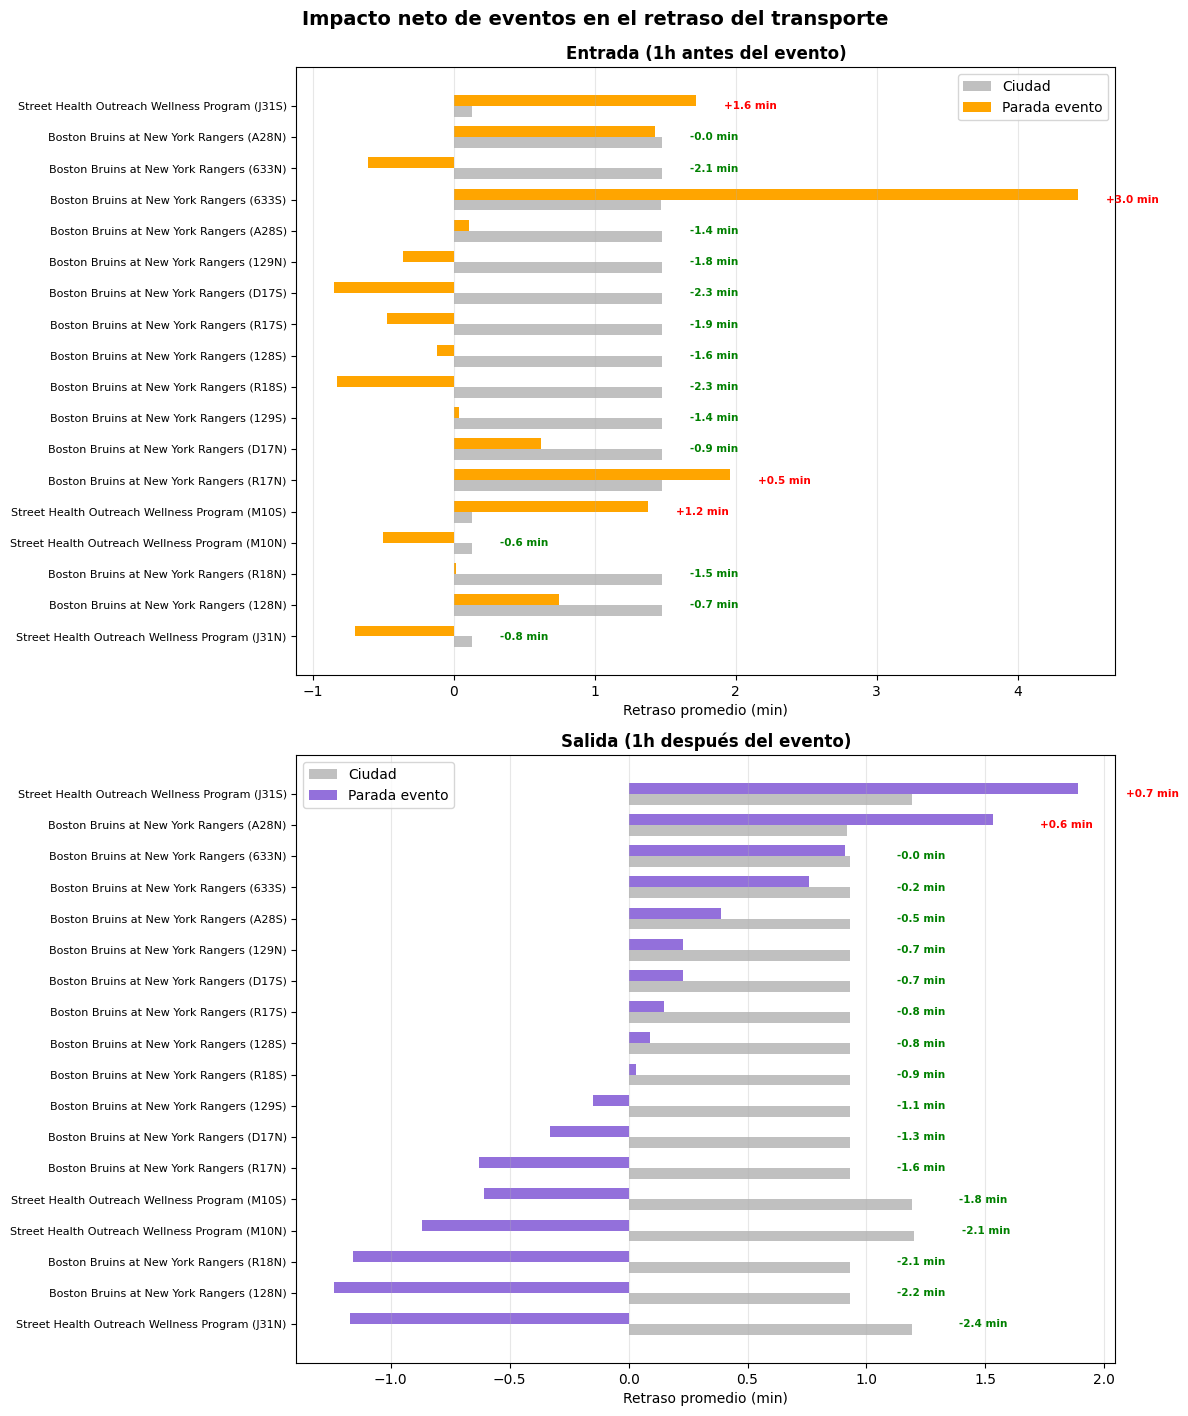

In [70]:
import matplotlib.pyplot as plt
import numpy as np

etiquetas = df_impacto['Evento'] + ' (' + df_impacto['Parada'].astype(str) + ')'
y = np.arange(len(etiquetas))
alto = 0.35

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, max(10, len(etiquetas) * 0.8)))


ax1.barh(y + alto/2, df_impacto['Retraso Ciudad Entrada (Mins)'], alto, label='Ciudad', color='silver')
ax1.barh(y - alto/2, df_impacto['Retraso Parada Entrada (Mins)'], alto, label='Parada evento', color='orange')
for i, val in enumerate(df_impacto['Impacto NETO Entrada (Mins)']):
    xpos = max(df_impacto['Retraso Parada Entrada (Mins)'].iloc[i],
               df_impacto['Retraso Ciudad Entrada (Mins)'].iloc[i]) + 0.2
    color = 'red' if val > 0 else 'green'
    ax1.text(xpos, i, f'{val:+.1f} min', va='center', fontsize=7.5, fontweight='bold', color=color) #colocar el +-
ax1.set_title('Entrada (1h antes del evento)', fontweight='bold')
ax1.set_yticks(y)
ax1.set_yticklabels(etiquetas, fontsize=8)
ax1.set_xlabel('Retraso promedio (min)')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()


ax2.barh(y + alto/2, df_impacto['Retraso Ciudad Salida (Mins)'], alto, label='Ciudad', color='silver')
ax2.barh(y - alto/2, df_impacto['Retraso Parada Salida (Mins)'], alto, label='Parada evento', color='mediumpurple')
for i, val in enumerate(df_impacto['Impacto NETO Salida (Mins)']):
    xpos = max(df_impacto['Retraso Parada Salida (Mins)'].iloc[i],
               df_impacto['Retraso Ciudad Salida (Mins)'].iloc[i]) + 0.2
    color = 'red' if val > 0 else 'green'
    ax2.text(xpos, i, f'{val:+.1f} min', va='center', fontsize=7.5, fontweight='bold', color=color)
ax2.set_title('Salida (1h después del evento)', fontweight='bold')
ax2.set_yticks(y)
ax2.set_yticklabels(etiquetas, fontsize=8)
ax2.set_xlabel('Retraso promedio (min)')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

fig.suptitle('Impacto neto de eventos en el retraso del transporte', fontsize=14, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.94)
plt.show()

In [71]:
resumen_final = []

ventana = pd.Timedelta(hours=2)
fin_dia = pd.Timedelta(hours=23, minutes=59)

for index, fila in df_e.iterrows():
    evento_nombre = fila['nombre_evento']
    stop = fila['stop_id']
    hora_inicio = pd.to_timedelta(fila['hora_inicio'])
    hora_salida = pd.to_timedelta(fila['hora_salida_estimada'])

    df_parada = df_s[df_s['stop_id'] == stop]

    antes   = df_parada[(df_parada['td_real'] >= hora_inicio - ventana*4) & (df_parada['td_real'] < hora_inicio - ventana)]
    entrada         = df_parada[(df_parada['td_real'] >= hora_inicio - ventana)   & (df_parada['td_real'] < hora_inicio)]
    durante     = df_parada[(df_parada['td_real'] >= hora_inicio) & (df_parada['td_real'] <= hora_salida)]
    salida       = df_parada[(df_parada['td_real'] > hora_salida)  & (df_parada['td_real'] <= hora_salida + ventana)]
    despues = df_parada[(df_parada['td_real'] > hora_salida + ventana)]#& (df_parada['td_real'] <= fin_dia)]

    resumen_final.append({
        'Evento':      evento_nombre,
        'Parada':      stop,
        'Antes':       round(antes['delay_minutes'].mean(), 2),
        'Entrada':     round(entrada['delay_minutes'].mean(), 2),
        'Durante':     round(durante['delay_minutes'].mean(), 2),
        'Salida':        round(salida['delay_minutes'].mean(), 2),
        'Después': round(despues['delay_minutes'].mean(), 2),
    })

df_resumen = pd.DataFrame(resumen_final)
#display(df_resumen)

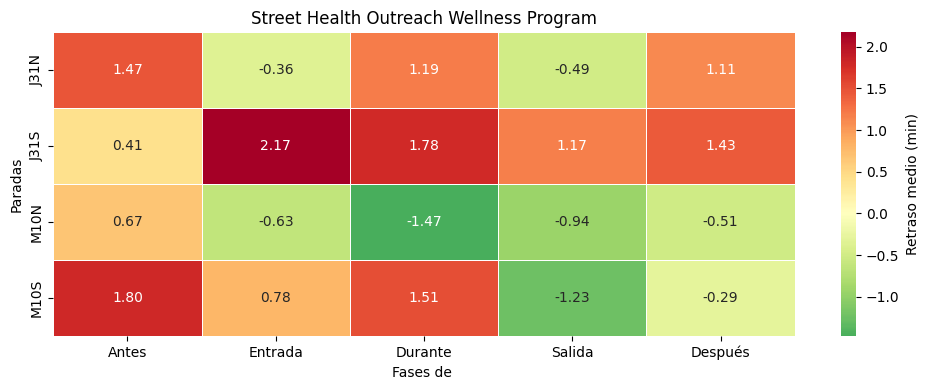

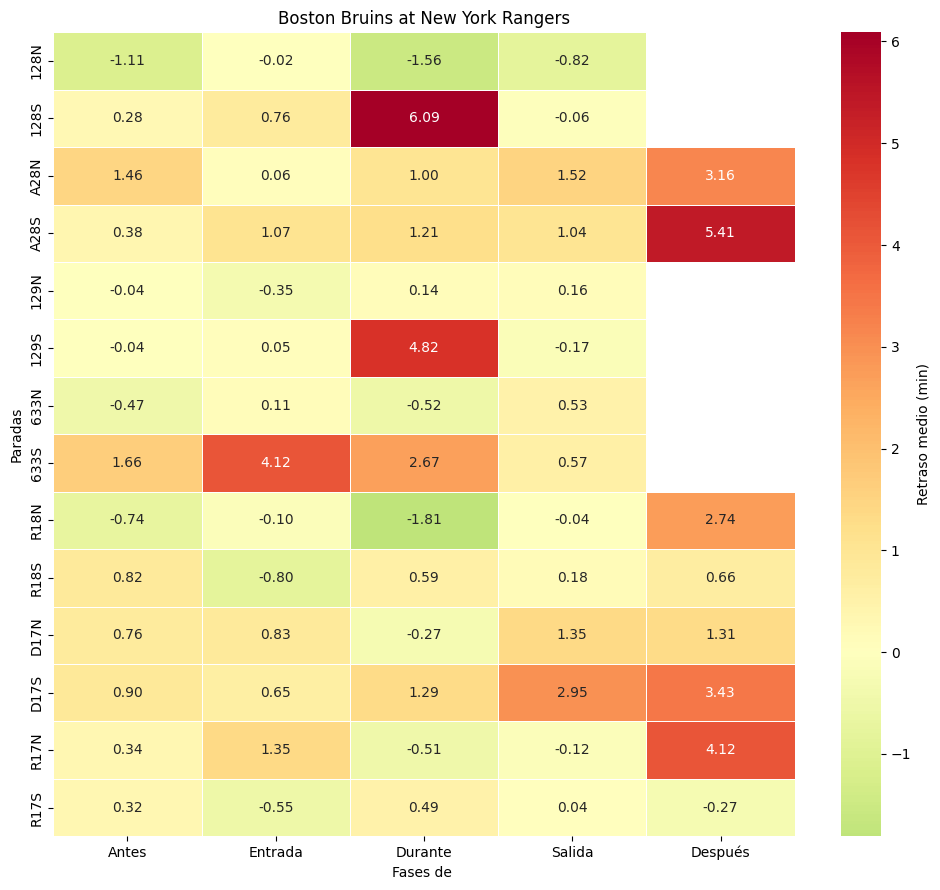

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns


fases = ['Antes', 'Entrada', 'Durante', 'Salida', 'Después']

for evento_nombre in df_resumen['Evento'].unique():
    df_plot = df_resumen[df_resumen['Evento'] == evento_nombre].set_index('Parada')[fases]
    
    plt.figure(figsize=(10, len(df_plot) * 0.5 + 2))
    sns.heatmap(
        df_plot,
        annot=True,
        fmt='.2f',
        cmap='RdYlGn_r',
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Retraso medio (min)'}
    )
    plt.title(f'{evento_nombre}')
    plt.xlabel('Fases de ')
    plt.ylabel('Paradas')
    plt.tight_layout()
    plt.show()

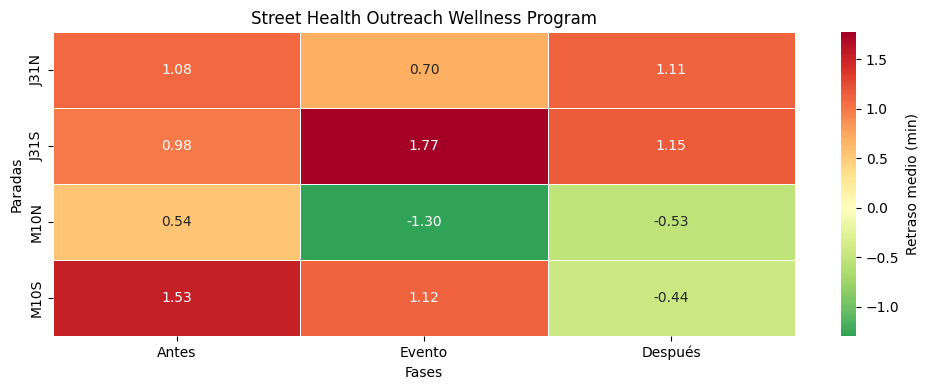

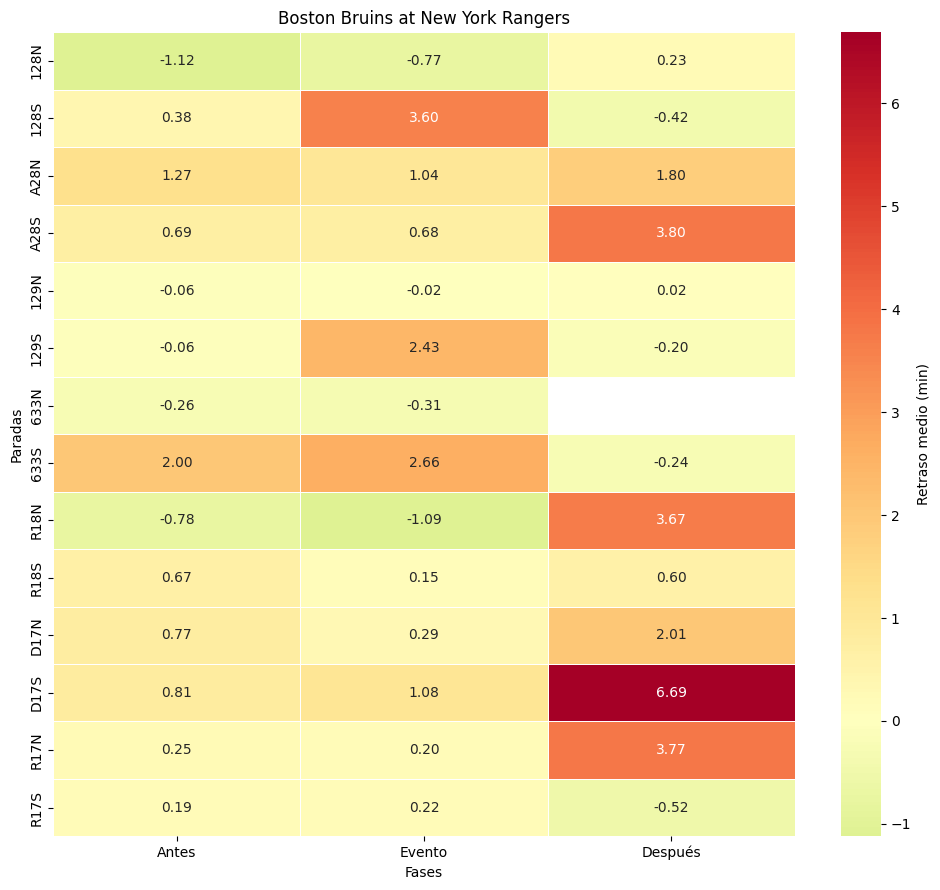

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

resumen_final_3 = []

ventana_antes = pd.Timedelta(hours=2)
ventana_evento = pd.Timedelta(hours=1.5)

for _, fila in df_e.iterrows():

    evento_nombre = fila["nombre_evento"]
    stop = fila["stop_id"]

    hora_inicio = pd.to_timedelta(fila["hora_inicio"])
    hora_salida = pd.to_timedelta(fila["hora_salida_estimada"])

    df_parada = df_s[df_s["stop_id"] == stop]

    antes = df_parada[
        (df_parada["td_real"] >= hora_inicio - ventana_antes*4) &
        (df_parada["td_real"] <  hora_inicio - ventana_evento)
    ]

    evento_ext = df_parada[
        (df_parada["td_real"] >= hora_inicio - ventana_evento) &
        (df_parada["td_real"] <= hora_salida + ventana_evento)
    ]

    despues = df_parada[
        (df_parada["td_real"] > hora_salida + ventana_evento)
    ]

    resumen_final_3.append({
        "Evento_nombre": evento_nombre,   # ✅ nombre real
        "Parada": stop,
        "Antes": round(antes["delay_minutes"].mean(), 2),
        "Evento": round(evento_ext["delay_minutes"].mean(), 2),
        "Después": round(despues["delay_minutes"].mean(), 2),
    })

df_resumen_3fases_nuevo = pd.DataFrame(resumen_final_3)

fases_plot = ["Antes", "Evento", "Después"]

for evento_nombre in df_resumen_3fases_nuevo["Evento_nombre"].unique():

    df_plot = (
        df_resumen_3fases_nuevo[
            df_resumen_3fases_nuevo["Evento_nombre"] == evento_nombre
        ]
        .set_index("Parada")[fases_plot]
    )

    plt.figure(figsize=(10, len(df_plot)*0.5 + 2))

    sns.heatmap(
        df_plot,
        annot=True,
        fmt=".2f",
        cmap="RdYlGn_r",
        center=0,
        linewidths=0.5,
        cbar_kws={"label": "Retraso medio (min)"}
    )

    plt.title(evento_nombre)

    plt.xlabel("Fases")
    plt.ylabel("Paradas")

    plt.tight_layout()
    plt.show()

GLOBAL (toda la red)


,service_date,Evento,Entrada,Salida,Total,Stops con extra (Entrada),Stops con extra (Salida)
0,2025-01-01,Boston Bruins at New York Rangers,210,177,387,333,398
1,2025-01-01,Street Health Outreach Wellness Program,152,208,360,396,323


LOCAL (paradas del evento según df_e)


,service_date,Evento,Entrada,Salida,Total,Stops evento,Stops evento con extra (Entrada),Stops evento con extra (Salida)
0,2025-01-01,Boston Bruins at New York Rangers,11,15,26,14,4,4
1,2025-01-01,Street Health Outreach Wellness Program,0,0,0,4,0,0


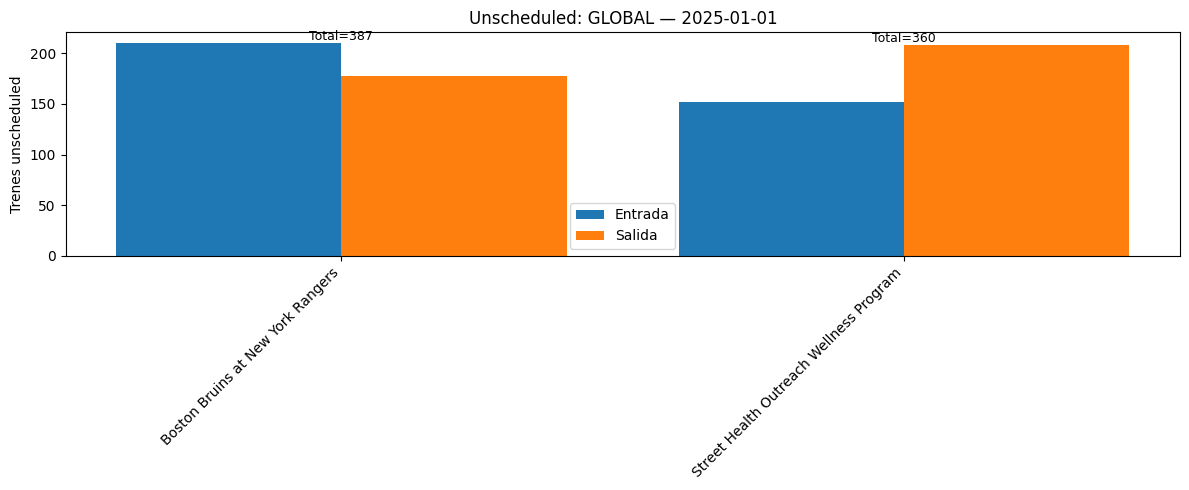

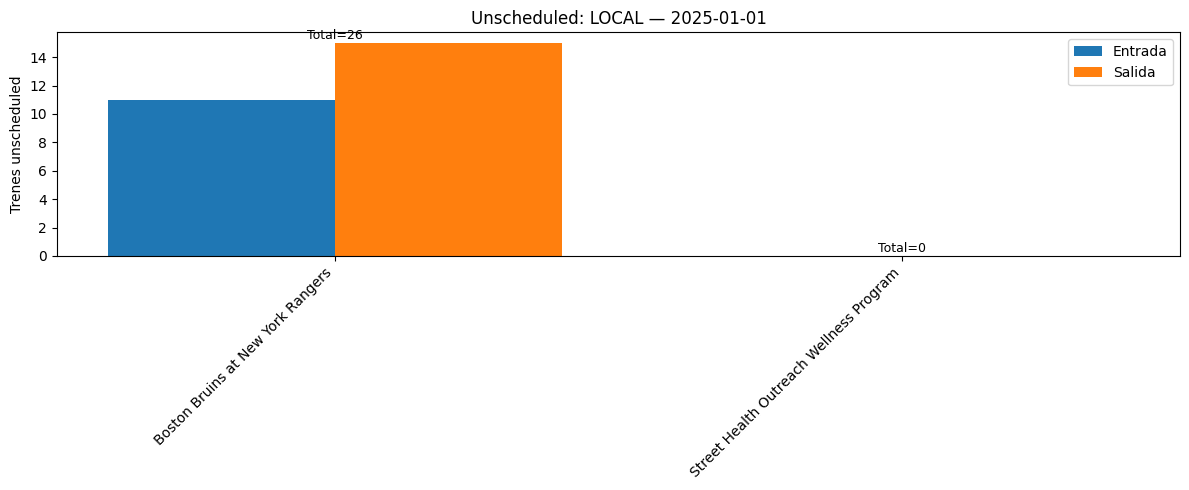

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

ventana = pd.Timedelta(hours=1.5)
fallback_service_date = "2025-01-01"

base_uns = "grupo5/cleaned/gtfs_clean_unscheduled"
filename_patterns = [
    "gtfs_unscheduled_{date}.parquet",
    "gtfs_clean_unscheduled_{date}.parquet",
    "gtfs_cleaned_unscheduled_{date}.parquet",
    "unscheduled_{date}.parquet",
]

df_e_local = df_e.copy()
if "service_date" not in df_e_local.columns:
    df_e_local["service_date"] = pd.to_datetime(fallback_service_date)
else:
    df_e_local["service_date"] = pd.to_datetime(df_e_local["service_date"])

fechas = sorted(df_e_local["service_date"].dt.strftime("%Y-%m-%d").unique())

def descargar_uns(fecha):
    for patt in filename_patterns:
        nombre = patt.format(date=fecha)
        path = f"{base_uns}/date={fecha}/{nombre}"
        try:
            tmp = download_df_parquet(
                access_key=access_key,
                secret_key=secret_key,
                object_name=path
            ).copy()
            tmp["service_date"] = pd.to_datetime(fecha)
            return tmp
        except Exception:
            continue
    return None

dfs = [descargar_uns(f) for f in fechas]
dfs = [d for d in dfs if d is not None]
if not dfs:
    raise ValueError("No se descargó ningún parquet de unscheduled. Revisa base_uns y filename_patterns.")

df_uns_all = pd.concat(dfs, ignore_index=True)

if "td_real" not in df_uns_all.columns:
    if "actual_seconds" in df_uns_all.columns:
        df_uns_all["td_real"] = pd.to_timedelta(df_uns_all["actual_seconds"], unit="s", errors="coerce")
    else:
        raise ValueError("El dataset unscheduled no tiene 'td_real' ni 'actual_seconds'.")

df_uns_all = df_uns_all.dropna(subset=["td_real"])
df_uns_all["td_real"] = pd.to_timedelta(df_uns_all["td_real"])

if "trip_uid" not in df_uns_all.columns:
    raise ValueError("El dataset unscheduled no tiene 'trip_uid'. No puedo contar trenes (trips) únicos de forma fiable.")

# Plantilla de eventos únicos por (service_date, nombre_evento) con sus horas (suponemos mismas horas en todas sus filas)
eventos = (
    df_e_local.groupby(["service_date", "nombre_evento"], as_index=False)
    .agg(
        hora_inicio=("hora_inicio", "first"),
        hora_salida_estimada=("hora_salida_estimada", "first")
    )
)

def calcular_global():
    rows = []
    for _, ev in eventos.iterrows():
        fecha = ev["service_date"]
        evento = ev["nombre_evento"]
        inicio = pd.to_timedelta(ev["hora_inicio"])
        salida = pd.to_timedelta(ev["hora_salida_estimada"])

        df_dia = df_uns_all[df_uns_all["service_date"] == fecha]

        entrada = df_dia[(df_dia["td_real"] >= inicio - ventana) & (df_dia["td_real"] < inicio)]
        salida_win = df_dia[(df_dia["td_real"] >= salida) & (df_dia["td_real"] <= salida + ventana)]

        rows.append({
            "service_date": fecha.date(),
            "Evento": evento,
            "Entrada": entrada["trip_uid"].nunique(),
            "Salida": salida_win["trip_uid"].nunique(),
            "Total": entrada["trip_uid"].nunique() + salida_win["trip_uid"].nunique(),
            "Stops con extra (Entrada)": entrada["stop_id"].nunique(),
            "Stops con extra (Salida)": salida_win["stop_id"].nunique(),
        })
    return pd.DataFrame(rows)

def calcular_local_multistop():
    rows = []
    for _, ev in eventos.iterrows():
        fecha = ev["service_date"]
        evento = ev["nombre_evento"]
        inicio = pd.to_timedelta(ev["hora_inicio"])
        salida = pd.to_timedelta(ev["hora_salida_estimada"])

        stops_evento = (
            df_e_local[(df_e_local["service_date"] == fecha) & (df_e_local["nombre_evento"] == evento)]
            ["stop_id"].dropna().unique().tolist()
        )

        df_dia = df_uns_all[df_uns_all["service_date"] == fecha]
        df_dia = df_dia[df_dia["stop_id"].isin(stops_evento)]

        entrada = df_dia[(df_dia["td_real"] >= inicio - ventana) & (df_dia["td_real"] < inicio)]
        salida_win = df_dia[(df_dia["td_real"] >= salida) & (df_dia["td_real"] <= salida + ventana)]

        rows.append({
            "service_date": fecha.date(),
            "Evento": evento,
            "Entrada": entrada["trip_uid"].nunique(),
            "Salida": salida_win["trip_uid"].nunique(),
            "Total": entrada["trip_uid"].nunique() + salida_win["trip_uid"].nunique(),
            "Stops evento": len(stops_evento),
            "Stops evento con extra (Entrada)": entrada["stop_id"].nunique(),
            "Stops evento con extra (Salida)": salida_win["stop_id"].nunique(),
        })
    return pd.DataFrame(rows)

df_global = calcular_global()
df_local = calcular_local_multistop()

print("GLOBAL (toda la red)")
display(df_global)

print("LOCAL (paradas del evento según df_e)")
display(df_local)

def plot_bars(df, titulo):
    for fecha, sub in df.groupby("service_date"):
        sub = sub.sort_values("Total", ascending=False)

        x = range(len(sub))
        width = 0.4

        plt.figure(figsize=(12, 5))
        plt.bar([i - width/2 for i in x], sub["Entrada"], width=width, label="Entrada")
        plt.bar([i + width/2 for i in x], sub["Salida"], width=width, label="Salida")

        for i, tot in enumerate(sub["Total"].tolist()):
            y = max(sub["Entrada"].iloc[i], sub["Salida"].iloc[i])
            plt.text(i, y + 0.05, f"Total={tot}", ha="center", va="bottom", fontsize=9)

        plt.xticks(list(x), sub["Evento"], rotation=45, ha="right")
        plt.ylabel("Trenes unscheduled")
        plt.title(f"{titulo} — {fecha}")
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_bars(df_global, "Unscheduled: GLOBAL")
plot_bars(df_local, "Unscheduled: LOCAL")

GLOBAL


,service_date,Evento,Antes,Durante,Después
0,2025-01-01,Boston Bruins at New York Rangers,209,593,171
1,2025-01-01,Street Health Outreach Wellness Program,116,1086,204


LOCAL


,service_date,Evento,Antes,Durante,Después
0,2025-01-01,Boston Bruins at New York Rangers,9,50,23
1,2025-01-01,Street Health Outreach Wellness Program,0,4,0


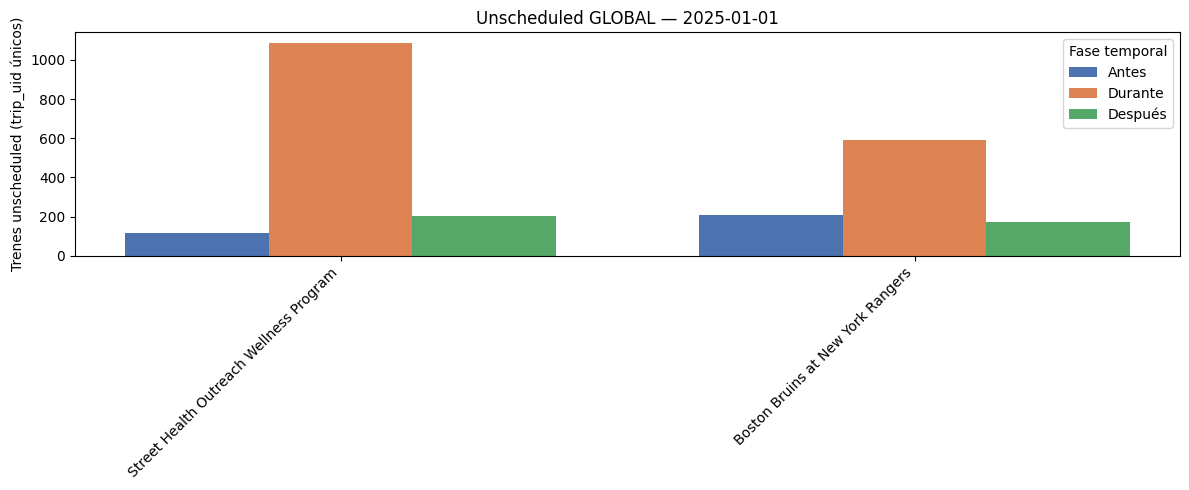

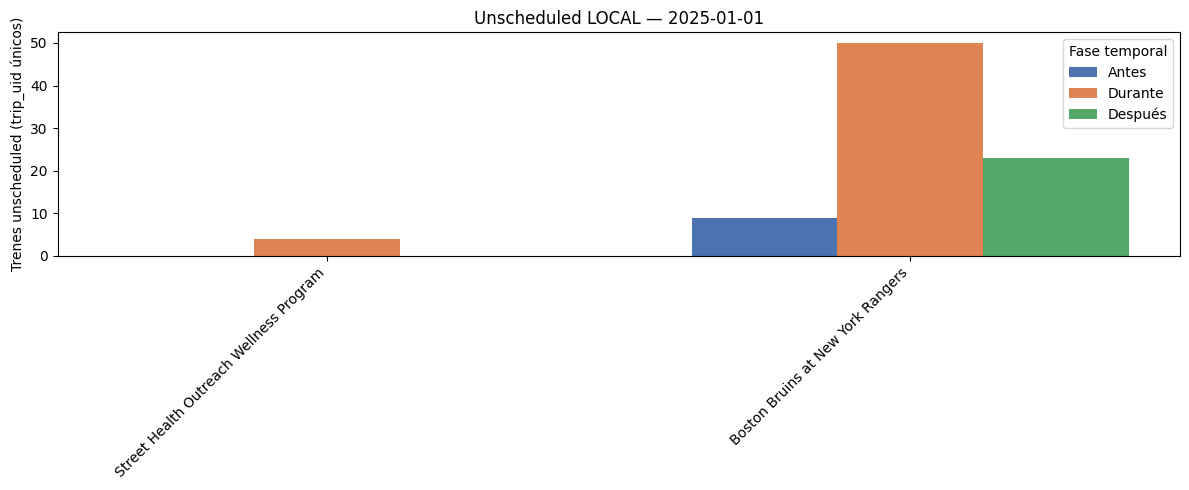

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

ventana = pd.Timedelta(hours=1.5)
fallback_service_date = "2025-01-01"

base_uns = "grupo5/cleaned/gtfs_clean_unscheduled"
filename_patterns = [
    "gtfs_unscheduled_{date}.parquet",
    "gtfs_clean_unscheduled_{date}.parquet",
    "gtfs_cleaned_unscheduled_{date}.parquet",
    "unscheduled_{date}.parquet",
]

df_e_local = df_e.copy()

if "service_date" not in df_e_local.columns:
    df_e_local["service_date"] = pd.to_datetime(fallback_service_date)
else:
    df_e_local["service_date"] = pd.to_datetime(df_e_local["service_date"])

fechas = sorted(
    df_e_local["service_date"].dt.strftime("%Y-%m-%d").unique()
)

def descargar_uns(fecha):
    for patt in filename_patterns:
        nombre = patt.format(date=fecha)
        path = f"{base_uns}/date={fecha}/{nombre}"
        try:
            tmp = download_df_parquet(
                access_key=access_key,
                secret_key=secret_key,
                object_name=path
            ).copy()
            tmp["service_date"] = pd.to_datetime(fecha)
            return tmp
        except Exception:
            continue
    return None

dfs = [descargar_uns(f) for f in fechas]
dfs = [d for d in dfs if d is not None]

if not dfs:
    raise ValueError("No se descargó ningún parquet unscheduled.")

df_uns_all = pd.concat(dfs, ignore_index=True)

if "td_real" not in df_uns_all.columns:
    if "actual_seconds" in df_uns_all.columns:
        df_uns_all["td_real"] = pd.to_timedelta(
            df_uns_all["actual_seconds"], unit="s"
        )
    else:
        raise ValueError("No existe td_real ni actual_seconds")

df_uns_all = df_uns_all.dropna(subset=["td_real"])
df_uns_all["td_real"] = pd.to_timedelta(df_uns_all["td_real"])

if "trip_uid" not in df_uns_all.columns:
    raise ValueError("trip_uid no encontrado")

eventos = (
    df_e_local
    .groupby(["service_date", "nombre_evento"], as_index=False)
    .agg(
        hora_inicio=("hora_inicio", "first"),
        hora_salida_estimada=("hora_salida_estimada", "first")
    )
)

def calcular_3_barras(scope="global"):

    rows = []

    for _, ev in eventos.iterrows():

        fecha = ev["service_date"]
        evento = ev["nombre_evento"]

        inicio = pd.to_timedelta(ev["hora_inicio"])
        salida = pd.to_timedelta(ev["hora_salida_estimada"])

        df_dia = df_uns_all[
            df_uns_all["service_date"] == fecha
        ]

        if scope == "local":
            stops_evento = (
                df_e_local[
                    (df_e_local["service_date"] == fecha) &
                    (df_e_local["nombre_evento"] == evento)
                ]["stop_id"]
                .dropna()
                .unique()
                .tolist()
            )

            df_dia = df_dia[
                df_dia["stop_id"].isin(stops_evento)
            ]

        antes = df_dia[
            (df_dia["td_real"] >= inicio - 2*ventana) &
            (df_dia["td_real"] < inicio - ventana)
        ]

        durante = df_dia[
            (df_dia["td_real"] >= inicio - ventana) &
            (df_dia["td_real"] <= salida + ventana)
        ]

        despues = df_dia[
            (df_dia["td_real"] > salida + ventana) &
            (df_dia["td_real"] <= salida + 2*ventana)
        ]

        rows.append({
            "service_date": fecha.date(),
            "Evento": evento,
            "Antes": antes["trip_uid"].nunique(),
            "Durante": durante["trip_uid"].nunique(),
            "Después": despues["trip_uid"].nunique(),
        })

    return (
        pd.DataFrame(rows)
        .groupby(["service_date","Evento"], as_index=False)
        .sum()
    )

df_global_3 = calcular_3_barras("global")
df_local_3 = calcular_3_barras("local")

print("GLOBAL")
display(df_global_3)

print("LOCAL")
display(df_local_3)

orden_eventos = (
    df_global_3
    .sort_values(["service_date","Durante"], ascending=[True,False])
    .groupby("service_date")["Evento"]
    .apply(list)
    .to_dict()
)

def plot_3_barras(df, titulo, orden_eventos):

    colores = {
        "Antes": "#4C72B0",
        "Durante": "#DD8452",
        "Después": "#55A868"
    }

    for fecha, sub in df.groupby("service_date"):

        orden = orden_eventos.get(fecha, sub["Evento"].tolist())
        sub = (
            sub.set_index("Evento")
               .reindex(orden)
               .reset_index()
        )

        x = range(len(sub))
        width = 0.25

        plt.figure(figsize=(12,5))

        plt.bar(
            [i-width for i in x],
            sub["Antes"],
            width,
            color=colores["Antes"],
            label="Antes"
        )

        plt.bar(
            x,
            sub["Durante"],
            width,
            color=colores["Durante"],
            label="Durante"
        )

        plt.bar(
            [i+width for i in x],
            sub["Después"],
            width,
            color=colores["Después"],
            label="Después"
        )

        plt.xticks(list(x), sub["Evento"],
                   rotation=45, ha="right")

        plt.ylabel("Trenes unscheduled (trip_uid únicos)")
        plt.title(f"{titulo} — {fecha}")

        plt.legend(title="Fase temporal")
        plt.tight_layout()
        plt.show()

plot_3_barras(df_global_3, "Unscheduled GLOBAL", orden_eventos)

plot_3_barras(df_local_3, "Unscheduled LOCAL", orden_eventos)